Confidence Intervals

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-916.644, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-529.162, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-861.136, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-769.870, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-530.151, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-903.074, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-936.478, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-885.570, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-902.789, Time=0.02 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-936.181, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-922.721, Time=0.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-933.603, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-937.689, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-887.476, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0]          

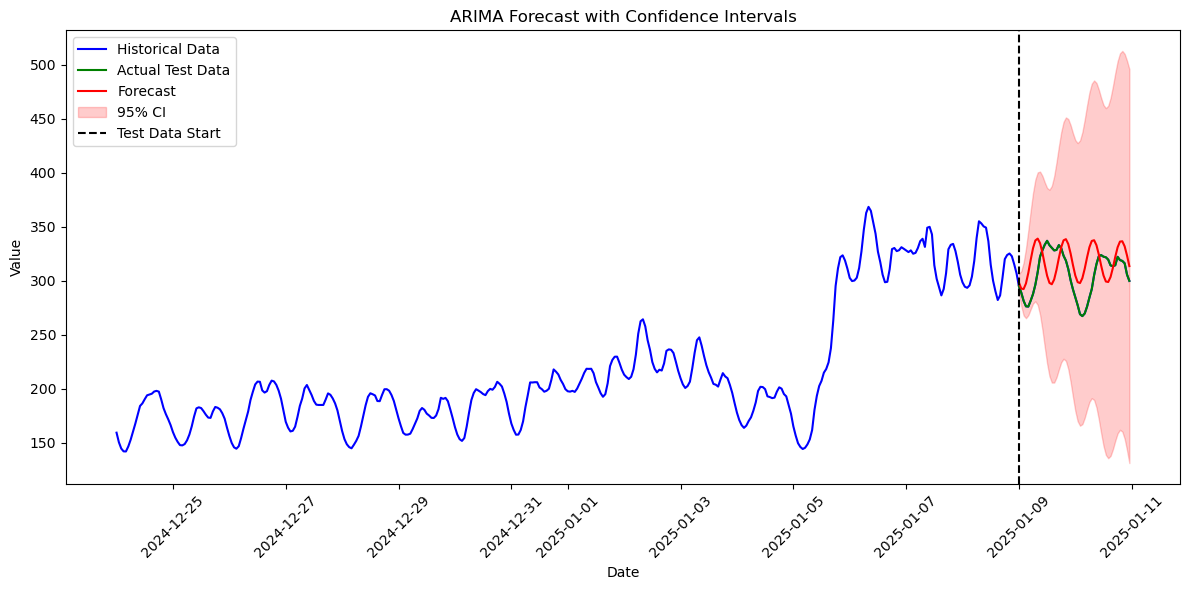

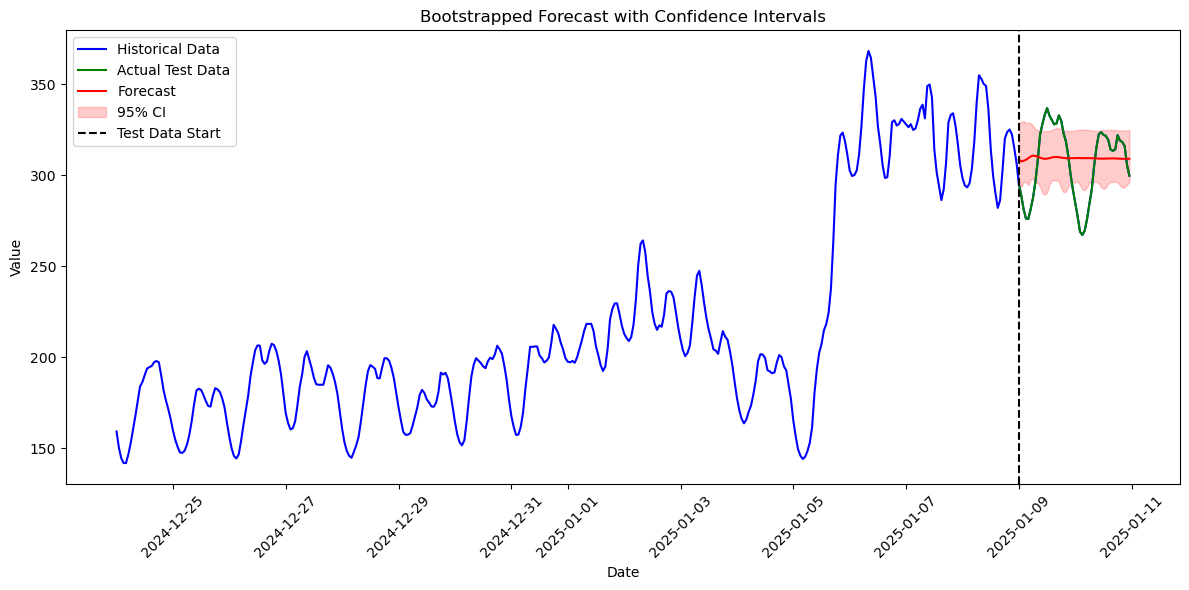

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

# Load and preprocess data
def load_and_preprocess_data(url):
    df = pd.read_csv(url)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    df = df.resample('h').mean().asfreq('h')
    df['values'] = df['values'].interpolate()

    scaler = StandardScaler()
    df['scaled_values'] = scaler.fit_transform(df[['values']])

    return df, scaler

# Forecast with ARIMA
def forecast_with_confidence(data, order, steps=48, confidence=0.95):
    model = ARIMA(data, order=order)
    fitted_model = model.fit()
    
    forecast_result = fitted_model.get_forecast(steps=steps)
    forecasts = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=1 - confidence)

    return forecasts, conf_int.iloc[:, 0], conf_int.iloc[:, 1]

# Bootstrap-based forecast confidence intervals
def bootstrap_forecast_ci(model_order, data, steps=48, n_bootstraps=100, confidence=0.95):
    forecasts = []
    
    for i in range(n_bootstraps):
        try:
            bootstrap_sample = data.sample(n=len(data), replace=True).sort_index()
            model = ARIMA(bootstrap_sample, order=model_order)
            fitted_model = model.fit()
            forecasts.append(fitted_model.forecast(steps=steps).values)
        except Exception as e:
            print(f"Bootstrap iteration {i} failed: {e}")

    if not forecasts:
        raise RuntimeError("All bootstrap iterations failed.")

    forecasts = np.array(forecasts)
    lower_ci = np.percentile(forecasts, (1 - confidence) / 2 * 100, axis=0)
    upper_ci = np.percentile(forecasts, (1 + confidence) / 2 * 100, axis=0)
    mean_forecast = np.mean(forecasts, axis=0)

    return mean_forecast, lower_ci, upper_ci

# Plot function
def plot_forecast_with_ci(historical_data, test_data, forecasts, lower_ci, upper_ci, title="Forecast with Confidence Intervals"):
    plt.figure(figsize=(12, 6))
    plt.plot(historical_data.index, historical_data.values, label='Historical Data', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
    
    forecast_index = test_data.index
    plt.plot(forecast_index, forecasts, 'r-', label='Forecast')
    plt.fill_between(forecast_index, lower_ci, upper_ci, color='r', alpha=0.2, label='95% CI')

    plt.axvline(x=test_data.index[0], color='black', linestyle='--', label="Test Data Start")
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{title}.png')
    plt.show()

# Main workflow
url = "https://raw.githubusercontent.com/kylejones200/time_series/refs/heads/main/ercot_load_data.csv"
df, scaler = load_and_preprocess_data(url)

train_data = df['scaled_values'].iloc[:-48]
test_data = df['scaled_values'].iloc[-48:]

# Find best ARIMA order
auto_model = auto_arima(train_data, seasonal=False, trace=True, suppress_warnings=True, stepwise=True)
best_order = auto_model.order
print(f"Using ARIMA order: {best_order}")

# ARIMA forecast with confidence intervals
forecasts, lower_ci, upper_ci = forecast_with_confidence(train_data, best_order, steps=48)

# Bootstrapped confidence intervals
boot_forecasts, boot_lower_ci, boot_upper_ci = bootstrap_forecast_ci(best_order, train_data, steps=48, n_bootstraps=50)

def inverse_transform_and_flatten(scaler, data):
    return scaler.inverse_transform(np.array(data).reshape(-1, 1)).flatten()


forecasts, lower_ci, upper_ci = map(lambda x: inverse_transform_and_flatten(scaler, x), [forecasts, lower_ci, upper_ci])
boot_forecasts, boot_lower_ci, boot_upper_ci = map(lambda x: inverse_transform_and_flatten(scaler, x), [boot_forecasts, boot_lower_ci, boot_upper_ci])
test_data_original = inverse_transform_and_flatten(scaler, test_data)


# Convert test data back into a Pandas Series
test_data_original_series = pd.Series(test_data_original, index=test_data.index)

# Plot results
plot_forecast_with_ci(df['values'], test_data_original_series, forecasts, lower_ci, upper_ci, title="ARIMA Forecast with Confidence Intervals")
plot_forecast_with_ci(df['values'], test_data_original_series, boot_forecasts, boot_lower_ci, boot_upper_ci, title="Bootstrapped Forecast with Confidence Intervals")
